# OCF Open Data PVNet Notebook

### This notebook builds upon the knowledge shared in:
[Understanding GFS Data](https://github.com/openclimatefix/open-data-pvnet/blob/main/notebooks/understanding_gfs_data.ipynb). 
👈 Check out the link if you want to better understand the details behind the GFS NWP data.

The following packages and versions should be installed locally:
```
boto3==1.36.1
botocore==1.36.1
fsspec==2025.3.2
matplotlib==3.9.1
numpy==1.26.4
ocf_data_sampler==0.2.22
pandas==2.2.0
requests==2.32.3
s3fs==2025.3.2
seaborn==0.13.2
typing-extensions==4.12.2
xarray==2024.11.0
zarr==2.18.3
pyyaml==6.0.1
```

In [1]:
# Import the following packages
import os
import yaml
from pathlib import Path
import re
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import pandas as pd
import numpy as np
from ocf_data_sampler.torch_datasets.datasets.pvnet_uk import PVNetUKRegionalDataset
import pandas as pd
from importlib.resources import files
import zarr
import fsspec
import s3fs
import matplotlib.pyplot as plt
from typing import Union, Optional, List
import seaborn as sns

In [2]:
# Utility function to get the absolute path to a resource
def get_resource_path(relative_path):
    """Get absolute path to resource"""
    notebook_dir = os.getcwd()  # current working directory of the notebook
    return os.path.join(notebook_dir, 'resources', relative_path)

In [3]:
# OCF zarr s3 bucket for 2023 GFS NWP data
zarr_path = "s3://ocf-open-data-pvnet/data/gfs/v4/2023.zarr/"

In [4]:
ds = xr.open_dataset(
    zarr_path,
    engine="zarr",
    backend_kwargs={"storage_options": {"anon": True}},
    chunks={},  # ← key for lazy loading via Dask
)

In [5]:
# General overview of the dataset
print(ds.info())

xarray.Dataset {
dimensions:
	init_time_utc = 1415 ;
	step = 17 ;
	latitude = 21 ;
	longitude = 21 ;

variables:
	float32 dlwrf(init_time_utc, step, latitude, longitude) ;
		dlwrf:GRIB_NV = 0 ;
		dlwrf:GRIB_Nx = 360 ;
		dlwrf:GRIB_Ny = 181 ;
		dlwrf:GRIB_cfName = unknown ;
		dlwrf:GRIB_cfVarName = dlwrf ;
		dlwrf:GRIB_dataType = fc ;
		dlwrf:GRIB_gridDefinitionDescription = Latitude/longitude. Also called equidistant cylindrical, or Plate Carree ;
		dlwrf:GRIB_gridType = regular_ll ;
		dlwrf:GRIB_iDirectionIncrementInDegrees = 1.0 ;
		dlwrf:GRIB_iScansNegatively = 0 ;
		dlwrf:GRIB_jDirectionIncrementInDegrees = 1.0 ;
		dlwrf:GRIB_jPointsAreConsecutive = 0 ;
		dlwrf:GRIB_jScansPositively = 0 ;
		dlwrf:GRIB_latitudeOfFirstGridPointInDegrees = 90.0 ;
		dlwrf:GRIB_latitudeOfLastGridPointInDegrees = -90.0 ;
		dlwrf:GRIB_longitudeOfFirstGridPointInDegrees = 0.0 ;
		dlwrf:GRIB_longitudeOfLastGridPointInDegrees = 359.0 ;
		dlwrf:GRIB_missingValue = 3.4028234663852886e+38 ;
		dlwrf:GRIB_name = 

In [6]:
# Check actual time values)
init_times = ds["init_time_utc"].values

print(f"First init time: {pd.to_datetime(init_times[1])}")
print(f"Last init time: {pd.to_datetime(init_times[-1])}")

First init time: 2023-01-01 06:00:00
Last init time: 2023-12-20 12:00:00


In [7]:
print("Latitudes:", ds.latitude.values)
print("Longitudes:", ds.longitude.values)

Latitudes: [65. 64. 63. 62. 61. 60. 59. 58. 57. 56. 55. 54. 53. 52. 51. 50. 49. 48.
 47. 46. 45.]
Longitudes: [-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


In [8]:
# Select only January 2023 for first samples
jan_ds = ds.sel(init_time_utc=slice("2023-01-01", "2023-01-31"))

In [9]:
# Construct forecast time
# [:, None]: Reshapes the 1D array (shape: 124) into a 2D array (shape: 124, 1)
# [None, :]: Reshapes the 1D array (shape: 17) into a 2D array (shape: 1, 17)
forecast_time = jan_ds.coords["init_time_utc"].values[:, None] + jan_ds.coords["step"].values[None, :]

# Flatten to get all unique forecast timestamps
forecast_time_flat = forecast_time.flatten()

# Print range and count
# The latest is February 2, 2023, 18:00 UTC, because the last initialization (January 31, 2023, 18:00)
# with a 48-hour step extends to 2023-01-31 18:00 + 48 hours = 2023-02-02 18:00
print(f"Time range: {forecast_time_flat.min()} to {forecast_time_flat.max()}")
print(f"Number of timesteps: {forecast_time_flat.size}")

# List variables
print(f"Variables: {list(jan_ds.data_vars)}")

Time range: 2023-01-01T00:00:00.000000000 to 2023-02-02T18:00:00.000000000
Number of timesteps: 2108
Variables: ['dlwrf', 'dswrf', 'hcc', 'lcc', 'mcc', 'prate', 'r', 'sde', 't', 'tcc', 'u10', 'u100', 'v10', 'v100', 'vis']


In [10]:
print(jan_ds.coords)

Coordinates:
  * init_time_utc  (init_time_utc) datetime64[ns] 992B 2023-01-01 ... 2023-01...
  * latitude       (latitude) float64 168B 65.0 64.0 63.0 ... 47.0 46.0 45.0
  * longitude      (longitude) float64 168B -10.0 -9.0 -8.0 ... 8.0 9.0 10.0
  * step           (step) timedelta64[ns] 136B 0 days 00:00:00 ... 2 days 00:...


In [11]:
# Display the dataset's metadata (attributes)
print(jan_ds.attrs)

{'Conventions': 'CF-1.7', 'GRIB_centre': 'kwbc', 'GRIB_centreDescription': 'US National Weather Service - NCEP', 'GRIB_edition': 2, 'GRIB_subCentre': 0, 'description': 'Global Forecast System', 'institution': 'US National Weather Service - NCEP', 'local_grib': '/root/data/gfs/20230101/subset_181c7ed8__gfs.t00z.pgrb2.1p00.f048', 'model': 'gfs', 'product': 'pgrb2.1p00', 'remote_grib': 'https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20230101/00/atmos/gfs.t00z.pgrb2.1p00.f048', 'search': ':[TLMH]CDC:|:[UV]GRD:(?:10|100) m|:RH:sigma|:(?:TMP|VIS|PRATE|SNOD|D[SL]WRF):surface|:RH:100 mb'}


In [12]:
# Check latitude and longitude ranges
print("\nLatitude range:")
print(f"Min: {jan_ds.latitude.min().values}")
print(f"Max: {jan_ds.latitude.max().values}")

print("\nLongitude range:")
print(f"Min: {jan_ds.longitude.min().values}")
print(f"Max: {jan_ds.longitude.max().values}")


Latitude range:
Min: 45.0
Max: 65.0

Longitude range:
Min: -10.0
Max: 10.0


In [13]:
# Get specific variables over time that are relevant to solar forecasting
solar_radiation = jan_ds["dswrf"]
cloud_cover = jan_ds["tcc"]

In [14]:
solar_radiation

<xarray.DataArray 'dswrf' (init_time_utc: 124, step: 17, latitude: 21,
                           longitude: 21)> Size: 4MB
dask.array<getitem, shape=(124, 17, 21, 21), dtype=float32, chunksize=(124, 10, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * init_time_utc  (init_time_utc) datetime64[ns] 992B 2023-01-01 ... 2023-01...
  * latitude       (latitude) float64 168B 65.0 64.0 63.0 ... 47.0 46.0 45.0
  * longitude      (longitude) float64 168B -10.0 -9.0 -8.0 ... 8.0 9.0 10.0
  * step           (step) timedelta64[ns] 136B 0 days 00:00:00 ... 2 days 00:...
Attributes: (12/33)
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           dswrf
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               W m**-2
    grid_mapping:                             gribfile_projection
    long_name:                                Downward short-wave radiation flux
    standard_name:                            unknown
    units:                                    W m**-2

In [15]:
cloud_cover

<xarray.DataArray 'tcc' (init_time_utc: 124, step: 17, latitude: 21,
                         longitude: 21)> Size: 4MB
dask.array<getitem, shape=(124, 17, 21, 21), dtype=float32, chunksize=(124, 10, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * init_time_utc  (init_time_utc) datetime64[ns] 992B 2023-01-01 ... 2023-01...
  * latitude       (latitude) float64 168B 65.0 64.0 63.0 ... 47.0 46.0 45.0
  * longitude      (longitude) float64 168B -10.0 -9.0 -8.0 ... 8.0 9.0 10.0
  * step           (step) timedelta64[ns] 136B 0 days 00:00:00 ... 2 days 00:...
Attributes: (12/33)
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tcc
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         atmosphere
    GRIB_units:                               %
    grid_mapping:                             gribfile_projection
    long_name:                                Total Cloud Cover
    standard_name:                            unknown
    units:                                    %

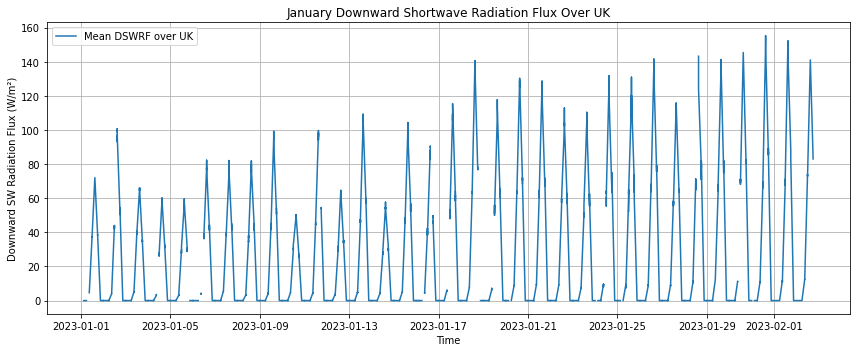

In [16]:
# Plot Downward Shortwave Radiation Flux Over UK in January
dswrf_mean = jan_ds['dswrf'].mean(dim=["latitude", "longitude"])
dswrf_flat = dswrf_mean.values.flatten()

df = pd.DataFrame({
    "forecast_time": forecast_time_flat,
    "dswrf": dswrf_flat
})

# 4. Sort by forecast_time and plot
df = df.sort_values("forecast_time")

plt.figure(figsize=(12, 5))
plt.plot(df["forecast_time"], df["dswrf"], label="Mean DSWRF over UK")
plt.xlabel("Time")
plt.ylabel("Downward SW Radiation Flux (W/m²)")
plt.title("January Downward Shortwave Radiation Flux Over UK")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<hr>

In [17]:
# Get the path to the GSP UK CSV file
csv_path = str(files("ocf_data_sampler") / "data/uk_gsp_locations_20220314.csv")

# Try loading the CSV
df_gsp_loc = pd.read_csv(csv_path, index_col="gsp_id")

# Print first few rows
print(df_gsp_loc.head())
print(f"✅ CSV loaded successfully with {df_gsp_loc.shape[0]} rows.")

                                                 geometry     x_osgb  \
gsp_id                                                                 
0       MULTIPOLYGON (((83979.99999999894 5180, 83940....  360053.47   
1       MULTIPOLYGON (((246878 54010, 246878 54110, 24...  274767.28   
2       POLYGON ((306749 715731, 306649 715731, 306649...  313426.72   
3       MULTIPOLYGON (((321979.9999999999 165059.99999...  306112.28   
4       MULTIPOLYGON (((513467.45966620307 179705.7363...  516917.84   

            y_osgb  
gsp_id              
0       466142.300  
1        61482.035  
2       714293.200  
3       171875.270  
4       182940.140  
✅ CSV loaded successfully with 318 rows.


<hr>

In [18]:
# Access PVLive data (ground truth to evaluate the model's performance)
s3_path = "s3://ocf-open-data-pvnet/data/uk/pvlive/v1/target_data_2023_01.zarr/"
ds_gsp = xr.open_dataset(
    s3_path,
    engine='zarr',
    backend_kwargs={"storage_options": {"anon": True}},
    chunks={},)

print(ds_gsp)

<xarray.Dataset> Size: 15MB
Dimensions:                (gsp_id: 318, datetime_gmt: 1489)
Coordinates:
  * datetime_gmt           (datetime_gmt) datetime64[ns] 12kB 2023-01-01 ... ...
  * gsp_id                 (gsp_id) int64 3kB 0 1 2 3 4 ... 313 314 315 316 317
Data variables:
    capacity_mwp           (gsp_id, datetime_gmt) float64 4MB dask.array<chunksize=(80, 745), meta=np.ndarray>
    generation_mw          (gsp_id, datetime_gmt) float64 4MB dask.array<chunksize=(80, 745), meta=np.ndarray>
    index                  (gsp_id, datetime_gmt) int64 4MB dask.array<chunksize=(80, 745), meta=np.ndarray>
    installedcapacity_mwp  (gsp_id, datetime_gmt) float64 4MB dask.array<chunksize=(80, 745), meta=np.ndarray>


In [19]:
# We only care about the first index 0, that are the UK's national values
print(ds_gsp["gsp_id"].values[:100])  # Print first 100 values to inspect

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


<hr>

## The PVNetUKRegionalDataset Class
[GitHub Link](https://github.com/openclimatefix/ocf-data-sampler/blob/main/ocf_data_sampler/torch_datasets/datasets/pvnet_uk.py)

The `PVNetUKRegionalDataset` class (source) is a PyTorch `Dataset` for UK regional PV power forecasting. It loads and preprocesses data (PV generation, weather, satellite imagery) for specified Grid Supply Points (GSPs).

Arguments:
`config_filename`: str (required, path to config file),
`start_time`: str | None (optional, ISO 8601 start time, defaults to None),
`end_time`: str | None (optional, ISO 8601 end time, defaults to None),
`gsp_ids`: list[int] | None (optional, list of GSP IDs, defaults to None) but should be 0.

### Now let's create the config_filename and call it gfs_config.yaml

In [20]:
# Let's use the raw test file to build our config yaml:
# https://raw.githubusercontent.com/openclimatefix/ocf-data-sampler/refs/heads/main/tests/test_data/configs/pvnet_test_config.yaml
gfs_config_filename = "gfs_config.yaml"
config_template_path = get_resource_path('assets/config_template.yaml')

# Read the template YAML file
try:
    with open(config_template_path, "r") as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print(f"Error: Template file {config_template_path} not found.")
    raise
except yaml.YAMLError:
    print(f"Error: Invalid YAML format in {config_template_path}.")
    raise

In [ ]:
# Create gfs_config.yaml file
config["general"]["name"] = "gfs_config"
config["general"]["description"] = "Configuration for GFS data sampling"

# Update GSP settings
config["input_data"]["gsp"]["zarr_path"] = "s3://ocf-open-data-pvnet/data/uk/pvlive/v1/target_data_2023_01.zarr"
config["input_data"]["gsp"]["time_resolution_minutes"] = 30
config["input_data"]["gsp"]["interval_start_minutes"] = -60
config["input_data"]["gsp"]["interval_end_minutes"] = 480
config["input_data"]["gsp"]["dropout_timedeltas_minutes"] = []
config["input_data"]["gsp"]["dropout_fraction"] = 0.0

# Replace NWP section with GFS settings
config["input_data"]["nwp"] = {
    "gfs": {
        "zarr_path": "s3://ocf-open-data-pvnet/data/gfs/v4/2023.zarr",
        "time_resolution_minutes": 180,
        "interval_start_minutes": -180,
        "interval_end_minutes": 540,
        "dropout_timedeltas_minutes": [],
        "dropout_fraction": 0.0,
        "image_size_pixels_height": 10,
        "image_size_pixels_width": 10,
        "public": True,
        "provider": "gfs",
        "channels": [
            "dlwrf", "dswrf", "hcc", "mcc", "lcc", "prate", "r", "t", "tcc",
            "u10", "u100", "v10", "v100", "vis"
        ],
        "normalisation_constants": {
            "dlwrf": {"mean": 298.342, "std": 96.305916},
            "dswrf": {"mean": 168.12321, "std": 246.18533},
            "hcc": {"mean": 35.272, "std": 42.525383},
            "lcc": {"mean": 43.578342, "std": 44.3732},
            "mcc": {"mean": 33.738823, "std": 43.150745},
            "prate": {"mean": 2.8190969e-05, "std": 0.00010159573},
            "r": {"mean": 18.359747, "std": 25.440672},
            "sde": {"mean": 0.36937004, "std": 0.43345627},
            "t": {"mean": 278.5223, "std": 22.825893},
            "tcc": {"mean": 66.841606, "std": 41.030598},
            "u10": {"mean": -0.0022310058, "std": 5.470838},
            "u100": {"mean": 0.0823025, "std": 6.8899174},
            "v10": {"mean": 0.06219831, "std": 4.7401133},
            "v100": {"mean": 0.0797807, "std": 6.076132},
            "vis": {"mean": 19628.32, "std": 8294.022},
            "u": {"mean": 11.645444, "std": 10.614556},
            "v": {"mean": 0.12330122, "std": 7.176398}
        }
    }
}


# Remove satellite and solar_position sections
config["input_data"].pop("satellite", None)
config["input_data"].pop("solar_position", None)

# Save the modified configuration to a new YAML file
output_config_path = get_resource_path("assets/gfs_config.yaml")
with open(output_config_path, "w") as file:
    yaml.safe_dump(config, file, sort_keys=False)

print(f"Configuration saved to {output_config_path}")

In [24]:
# Load dataset using the configuration file
file = config_template_path = get_resource_path('assets/example_configuration.yaml')
dataset = PVNetUKRegionalDataset(config_filename=output_config_path, gsp_ids=[0])

# Print dataset info
print(f"Dataset length: {len(dataset)}")
print("Loading sample...")
sample = dataset[0]
print(f"Sample keys: {sample.keys()}")
print("Loading sample completed...")

Dataset length: 1467
Loading sample...
Sample keys: dict_keys(['nwp', 'gsp', 'gsp_nominal_capacity_mwp', 'gsp_effective_capacity_mwp', 'gsp_time_utc', 'gsp_t0_idx', 'gsp_id', 'gsp_x_osgb', 'gsp_y_osgb'])
Loading sample completed...


In [26]:
# Inspect a sample
for key, value in sample.items():
    print(f"{key}: type={type(value)}, shape={getattr(value, 'shape', 'N/A')}")

print(f"\n Sample dataset[0] details: {sample}")

nwp: type=<class 'dict'>, shape=N/A
gsp: type=<class 'numpy.ndarray'>, shape=(19,)
gsp_nominal_capacity_mwp: type=<class 'numpy.ndarray'>, shape=()
gsp_effective_capacity_mwp: type=<class 'numpy.ndarray'>, shape=()
gsp_time_utc: type=<class 'numpy.ndarray'>, shape=(19,)
gsp_t0_idx: type=<class 'float'>, shape=N/A
gsp_id: type=<class 'int'>, shape=N/A
gsp_x_osgb: type=<class 'float'>, shape=N/A
gsp_y_osgb: type=<class 'float'>, shape=N/A

 Sample dataset[0] details: {'nwp': {'gfs': {'nwp': array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00

## More sampling details to follow as contributors add to this project...